In [1]:
import cv2
import numpy as np
import glob
from scipy.ndimage import imread # For reading gifs
import matplotlib.pyplot as plt
from skimage.morphology import binary_dilation
%matplotlib inline

plt.style.use('bmh')

In [194]:
def imshow_big(img, ax='on', cmap='jet'):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap)
    plt.axis(ax);

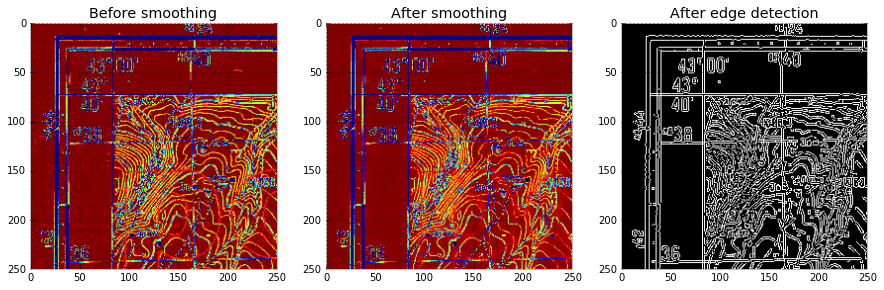

In [188]:
img_fp = './k38_lom_imgs/100k--k38-015.gif'
img = imread(img_fp)

gray = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
smoothed = cv2.bilateralFilter(gray.copy(), 10, 30, 12)

f, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(gray[:250, :250]); axs[0].set_title('Before smoothing');
axs[1].imshow(smoothed[:250, :250]); axs[1].set_title('After smoothing');
edges = cv2.Canny(smoothed.copy(), 110, 230)
axs[2].imshow(edges[:250, :250], cmap='gray'); axs[2].set_title('After edge detection')

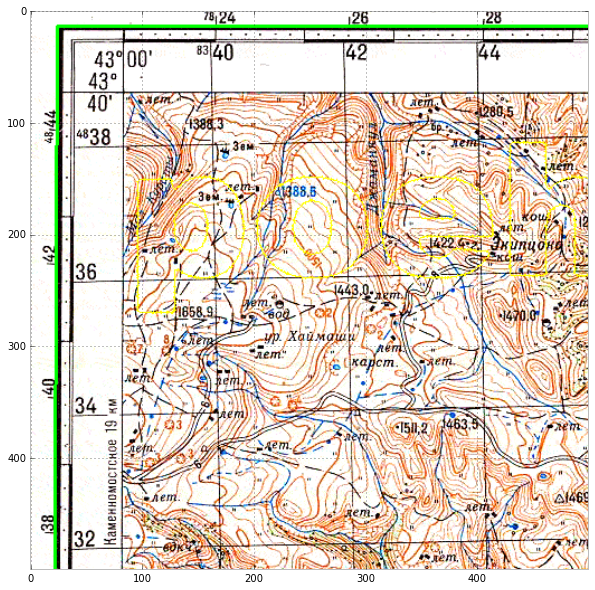

In [196]:
dilated = binary_dilation(edges)
_, cnts, hier = cv2.findContours(dilated.astype('uint8'), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
border = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
perimeter = cv2.arcLength(border, True)
borderContour = [cv2.approxPolyDP(border, 0.1*perimeter, True)]
dst = np.zeros(gray.shape)
dst = cv2.drawContours(img.copy(), borderContour, -1, color=[0, 255, 0], thickness=2)
imshow_big(dst[:500, :500], cmap='gray')